In [1]:
import pathlib
import pandas as pd
import eli5
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report

/Users/1150704/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Load pre-processed train and test data
# Load data
data_path = pathlib.Path().cwd().parent / "data"
print(f"Logging info - Loading data from {data_path}")
train_df = pd.read_csv(f"{data_path}/train.csv", keep_default_na=False)
test_df = pd.read_csv(f"{data_path}/test.csv", keep_default_na=False)

Logging info - Loading data from /Users/1150704/Documents/mywork/zip_product_classification/data


In [3]:
# Create a new column that combines product description and name 
train_df["name_desc"] = train_df["name"] + " " + train_df["desc"]
test_df["name_desc"] = test_df["name"] + " " + test_df["desc"]

In [4]:
# build a pipeline 
pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,3), stop_words='english', 
                                              sublinear_tf=True, max_features=50000, min_df=2)),
                     #('chi', SelectKBest(chi2, k=10000)),
                     ('clf', LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', 
                                                random_state=17, verbose=0, 
                                                multi_class='multinomial',
                                                fit_intercept=True))
                    ])

In [5]:
pipeline.fit(train_df['name_desc'], train_df['cat0_cat1_cat2'])

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 3), stop_words='english',
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=100.0, multi_class='multinomial',
                                    n_jobs=4, random_state=17))])

In [6]:
pred_level_3 = pipeline.predict(test_df['name_desc'])

In [7]:
pred_level_3

array(['fashion|fashion-clothing|fashion-clothing-maternity',
       'fashion|fashion-clothing|fashion-clothing-pants, fashion-clothing-sleepwear',
       'fashion|fashion-clothing|fashion-clothing-jumpsuits-playsuits',
       ..., 'fashion|fashion-clothing|fashion-clothing-sleepwear',
       'hardware|hardware-tools|hardware-tools-power-tools',
       'fashion|fashion-clothing|fashion-clothing-maternity'],
      dtype=object)

In [8]:
pred_level_0 = [el.split('|')[0] for el in pred_level_3]
pred_level_1 = [el.split('|')[1] for el in pred_level_3]
pred_level_2 = [el.split('|')[2] for el in pred_level_3]

## Evaluation

In [9]:
print(classification_report(
    y_true=test_df['cat0'], 
    y_pred=pred_level_0,
    digits=4)
)

              precision    recall  f1-score   support

 electronics     0.9843    0.9835    0.9839      1211
     fashion     0.9995    0.9988    0.9991     17303
    hardware     0.9908    0.9900    0.9904      2509
        home     0.9921    0.9958    0.9940      4046

    accuracy                         0.9967     25069
   macro avg     0.9917    0.9920    0.9919     25069
weighted avg     0.9967    0.9967    0.9967     25069



In [10]:
print(classification_report(
    y_true=test_df['cat1'], 
    y_pred=pred_level_1,
    digits=4)
)

                              precision    recall  f1-score   support

      electronics-smart-home     0.9843    0.9835    0.9839      1211
                fashion-bags     0.9992    0.9989    0.9990      2615
            fashion-clothing     0.9995    0.9987    0.9991     14688
              hardware-tools     0.9908    0.9900    0.9904      2509
home-furniture, home-kitchen     0.9921    0.9958    0.9940      4046

                    accuracy                         0.9966     25069
                   macro avg     0.9932    0.9934    0.9933     25069
                weighted avg     0.9967    0.9966    0.9967     25069



In [11]:
print(classification_report(
    y_true=test_df['cat2'], 
    y_pred=pred_level_2,
    digits=4)
)

                                                                  precision    recall  f1-score   support

             electronics-smart-home-security-cameras-and-systems     0.9843    0.9835    0.9839      1211
                                 fashion-bags-laptop-tablet-bags     0.9992    0.9989    0.9990      2615
                            fashion-clothing-jumpsuits-playsuits     0.9817    0.9863    0.9840      3217
fashion-clothing-jumpsuits-playsuits, fashion-clothing-sleepwear     0.9250    0.6167    0.7400        60
     fashion-clothing-jumpsuits-playsuits, fashion-clothing-tops     0.9302    0.8989    0.9143       356
                                      fashion-clothing-maternity     0.9989    0.9949    0.9969      4746
              fashion-clothing-pants, fashion-clothing-sleepwear     0.9351    0.9316    0.9333       263
                                      fashion-clothing-sleepwear     0.9858    0.9901    0.9880      6046
                                      hardwar

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    cm = confusion_matrix(y_true, y_pred).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

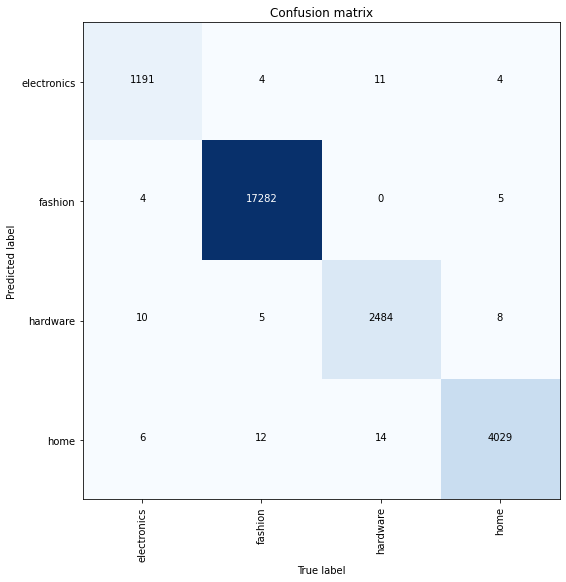

In [14]:
plot_confusion_matrix(
    y_true=test_df['cat0'],
    y_pred=pred_level_0, 
    classes=sorted(test_df['cat0'].unique()),
    figsize=(8, 8)
)

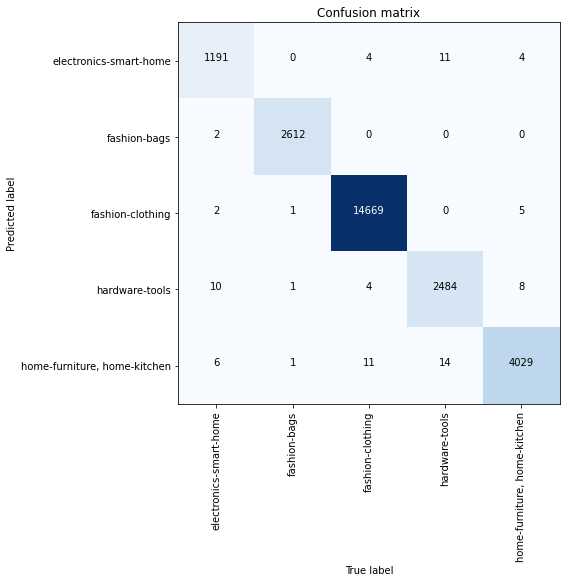

In [19]:
plot_confusion_matrix(
    y_true=test_df['cat1'],
    y_pred=pred_level_1, 
    classes=sorted(test_df['cat1'].unique()),
    figsize=(8, 8)
)

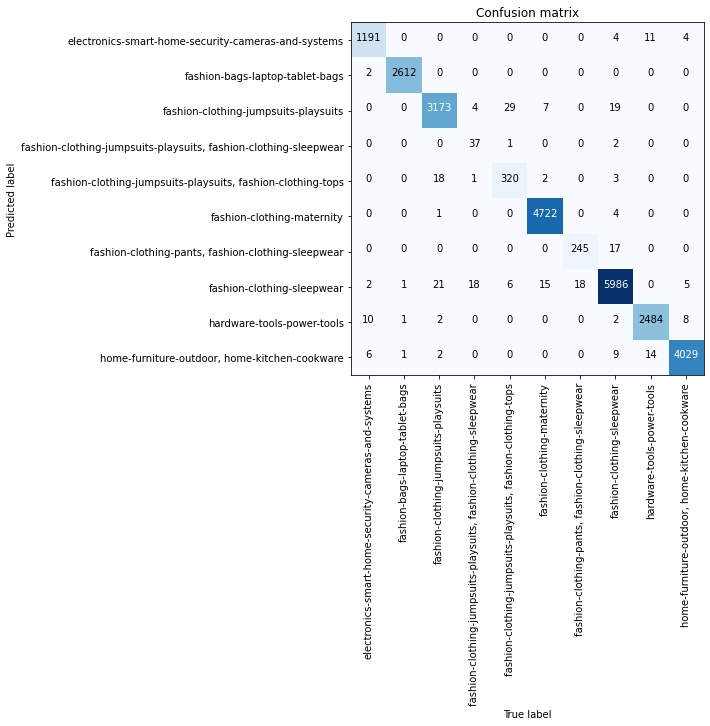

In [21]:
plot_confusion_matrix(
    y_true=test_df['cat2'],
    y_pred=pred_level_2, 
    classes=sorted(test_df['cat2'].unique()),
    figsize=(10, 10)
)

## Explainations

In [12]:
eli5.show_weights(
    estimator=pipeline.named_steps['clf'],
    vec=pipeline.named_steps['vect'])